MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [3]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -9 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [6]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [8]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [10]:
# Replace missing codes in ANXIOUS column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [11]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [13]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [15]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [16]:
df[['AAGE','SEX','ETHUKEUL','NATIDB11','MARDY6','ILODEFR','TEN1','DISCURR20','HIQUL15D','IN0792SM','RELIGE','GOR9d']].isna().sum()

AAGE           0
SEX            0
ETHUKEUL     259
NATIDB11     419
MARDY6         0
ILODEFR        0
TEN1         181
DISCURR20      0
HIQUL15D     171
IN0792SM     391
RELIGE       477
GOR9d          0
dtype: int64

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define relevant columns
columns = {
    'AGE': 'AAGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'DISCURR20',
    'QUALIFICATION': 'HIQUL15D',
    'SOCIO_ECON': 'IN0792SM',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d',
}

# Add 'Wellbeing' to list of relevant columns
relevant_cols = list(columns.values()) + ['Wellbeing']

# Drop rows with missing values in relevant predictors or target
model_df = cleaned.dropna(subset=relevant_cols).copy()

# Define features and target
X = model_df[[v for v in columns.values()]]
y = model_df['Wellbeing']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# First split - 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42
)

# Second split- 50% of temp = 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Output shapes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (113859, 21), Validation: (24399, 21), Test: (24399, 21)


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 2: Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Step 3: Evaluate performance
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.3f}")
print(f"Validation R²: {r2:.3f}")

Validation MSE: 2.399
Validation R²: 0.066


In [48]:
# Create DataFrame of coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top 15 features by absolute influence
coeff_df.head(15).style.format({'Coefficient': '{:.4f}'})

,Feature,Coefficient
4,MARDY6,-0.5772
6,TEN1,-0.1478
1,SEX,0.0662
19,GOR9d_S99999999,0.0550
0,AAGE,0.0446
7,DISCURR20,0.0398
16,GOR9d_E12000007,-0.0317
5,ILODEFR,0.0301
20,GOR9d_W99999999,0.0295
15,GOR9d_E12000006,0.0241


So these are the top 15 attritubes that affects wellbeing from higher influence to low.

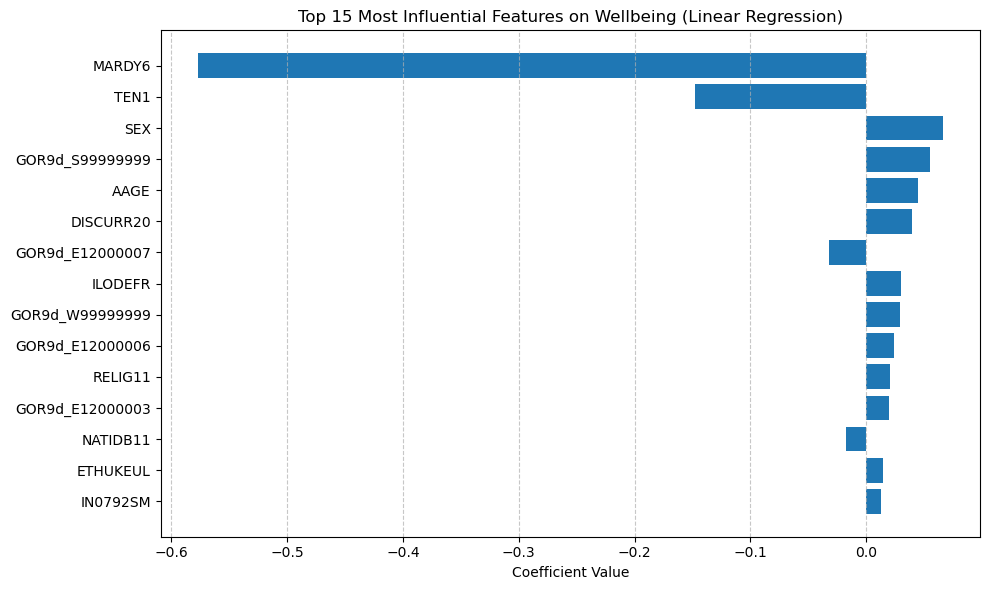

In [51]:
import matplotlib.pyplot as plt


# Bar chart of top 15 features by absolute coefficient
top15 = coeff_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top15['Feature'][::-1], top15['Coefficient'][::-1])  # reverse for descending order
plt.xlabel('Coefficient Value')
plt.title('Top 15 Most Influential Features on Wellbeing (Linear Regression)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()